In [1]:
from mattergen.diffusion.diffusion_loss import *
from mattergen.common.data.chemgraph import *
import torch
import matplotlib.pyplot as plt
import json
from ase.io import read


torch.Size([3596, 100])


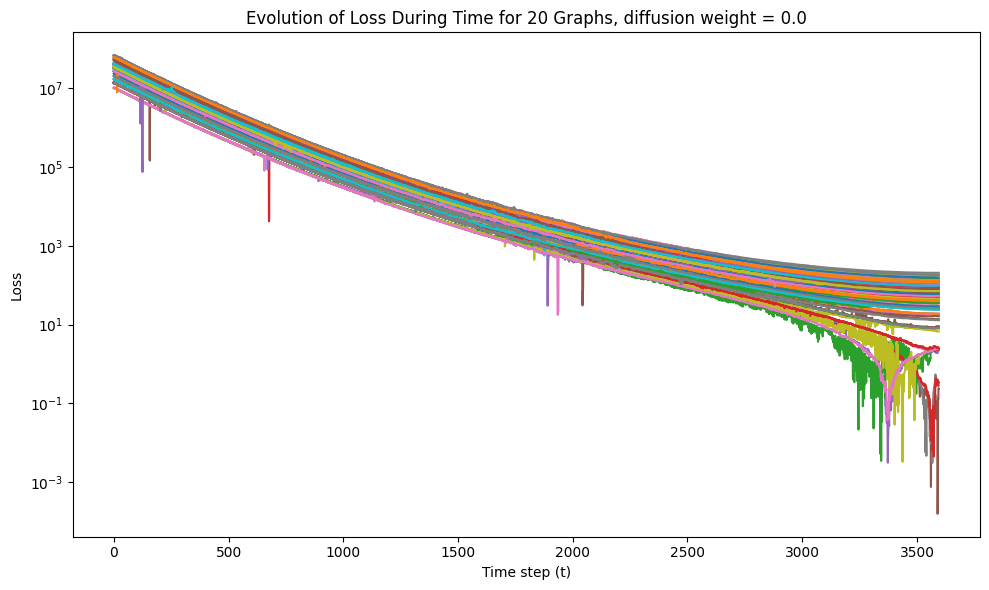

In [7]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

torch.Size([3596, 100])


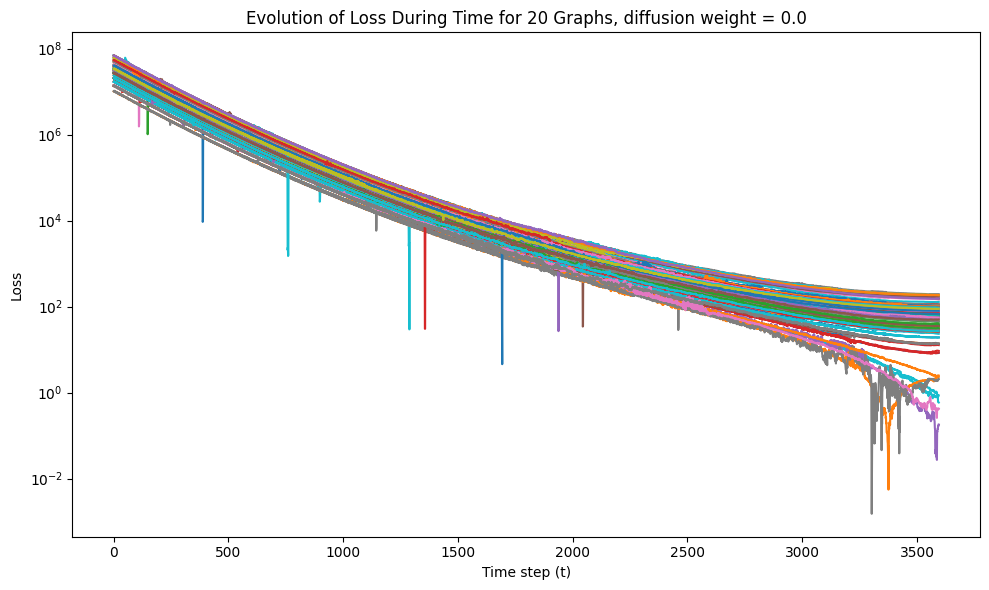

In [8]:
with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix2 = torch.tensor(data)
print(matrix2.shape)

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(matrix2.shape[1]):
    plt.plot(10**5*matrix2[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs, diffusion weight = 0.0')
plt.yscale('log')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [4]:
def compute_volumes_extxyz_file(extxyz_file):
    volumes = []
    # Read all frames from the extxyz file
    atoms_list = read(extxyz_file, index=':')
    for atoms in atoms_list:
        volumes.append(atoms.get_volume())
    return volumes


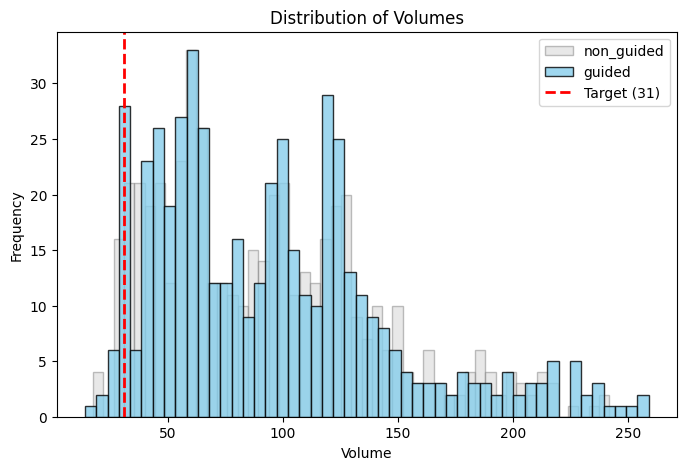

In [3]:
# Paths the extxyz files
extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

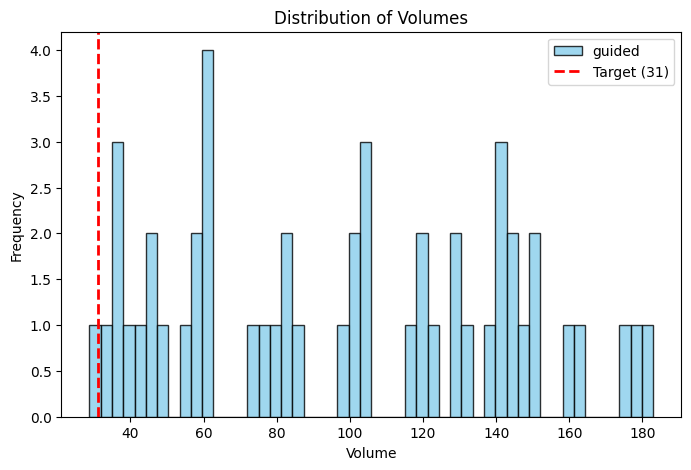

In [5]:
# Paths the extxyz files
#extxyz_file_non_guided = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_non_guided/generated_crystals.extxyz"
extxyz_file_with_target = r"/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_guided/generated_crystals.extxyz"

# Compute volumes for both sets
#volumes_non_guided = compute_volumes_extxyz_file(extxyz_file_non_guided)
volumes_with_target = compute_volumes_extxyz_file(extxyz_file_with_target)

plt.figure(figsize=(8, 5))
# Plot "non_guided" as background
#plt.hist(volumes_non_guided, bins=50, color='lightgray', edgecolor='gray', alpha=0.5, label='non_guided')
# Plot "with target" on top
plt.hist(volumes_with_target, bins=50, color='skyblue', edgecolor='black', alpha=0.8, label='guided')
plt.axvline(31, color='red', linestyle='--', linewidth=2, label='Target (31)')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.title('Distribution of Volumes')
plt.legend()
plt.show()

In [2]:
import torch
from pymatgen.core.periodic_table import Element
from ase.io import read

def compute_species_matrix(cell: torch.Tensor,
                           frac: torch.Tensor,
                           atomic_numbers: list[int],
                           kernel: str = "gaussian",
                           sigma: float = 1.0,
                           r_cut: float | None = None, # good for Mo-Si-B-P (maybe calculate dynamically?)
                           alpha: float = 8.0
                           ) -> torch.Tensor:
    """
    Compute a differentiable species‐pair matrix f (n_types × n_types), where
        f[a,b] = (1 / |A_a|) * sum_{i in A_a} sum_{j in A_b} g(d_ij),
    under PBC.  g(d) is either:
      - Gaussian:      exp[−(d/sigma)^2]
      - Soft‐cutoff:   sigmoid(alpha * (r_cut − d))

    Args:
      cell      (3×3) Tensor: rows are lattice vectors.
      positions (N×3) Tensor: Cartesian coords, requires_grad=True if you want ∂/∂pos.
      symbols   list of N strings: e.g. ["Si","Si",...,"B","B"]
      kernel    "gaussian" or "sigmoid"
      sigma     width for Gaussian (Å)
      r_cut     cutoff for sigmoid (Å) better be taken
      alpha     sharpness for sigmoid (~4/alpha transition region )

    Returns:
      f (n_types × n_types) Tensor, with gradients flowing to cell and positions.
    """

    # 1) map symbols → Mendeleev numbers → contiguous labels 0..n_types−1
    unique = sorted(set(atomic_numbers))
    lbl = {m: i for i, m in enumerate(unique)}
    types = torch.tensor([lbl[m] for m in atomic_numbers], dtype=torch.long, device=frac.device)
    n_types = types.max().item() + 1
    N = atomic_numbers.shape[0]

    if r_cut is None:
        # Build the cutoff matrix
        a = torch.tensor([INTER_ATOMIC_CUTOFF[n] for n in atomic_numbers], device=frac.device).unsqueeze(1)  # (N, 1)
        b = torch.tensor([INTER_ATOMIC_CUTOFF[n] for n in atomic_numbers], device=frac.device).unsqueeze(0)  # (1, N)
        r_cut = a + b + 0.5  # (N, N)
        r_cut = r_cut.unsqueeze(2) + torch.zeros(27, device=frac.device)  # (N, 27*N)
        r_cut = r_cut.reshape((N,-1))


    # 2) PBC distances: distances entre chaque atome de la maille et chaque atome de la supermaille (images voisines)
    shifts = torch.stack(torch.meshgrid(
        torch.arange(-1, 2, device=frac.device),
        torch.arange(-1, 2, device=frac.device),
        torch.arange(-1, 2, device=frac.device),
        indexing='ij'
    ), dim=-1).reshape(-1, 3)  # (27, 3)

    frac_images = frac.unsqueeze(1) + shifts.unsqueeze(0)  # (N, 27, 3)
    frac_images = frac_images.reshape(-1, 3)  # (N*27, 3)

    # On calcule toutes les distances entre chaque atome de la maille centrale et chaque atome de la supermaille
    d = frac.unsqueeze(1) - frac_images.unsqueeze(0)  # (N, N*27, 3)
    dc = torch.matmul(d, cell)  # (N, N*27, 3)
    dist = dc.norm(dim=-1)      # (N, N*27)

    # 3) kernel
    if kernel == "gaussian":
        G = torch.exp(- (dist / sigma).pow(2))
    elif kernel == "sigmoid":
        G = torch.sigmoid(alpha * (r_cut - dist))
    else:
        raise ValueError("kernel must be 'gaussian' or 'sigmoid'")

    # 4) build f[a,b]
    masks = [(types == a).unsqueeze(1).float() for a in range(n_types)]
    f = torch.zeros((n_types, n_types), device=frac.device)
    for a in range(n_types):
        Ma = masks[a]
        ca = Ma.sum()
        if ca < 1e-8:
            continue
        for b in range(n_types):
            Mb = masks[b].T
            Mask = (Ma * Mb).unsqueeze(2) + torch.zeros(27, device=frac.device)  # (N, 27*N)
            Mask = Mask.reshape((N,-1))
            f[a, b] = (G * Mask).sum() /ca
    f = f - torch.eye(n_types, device=frac.device)  # remove self-interactions
    return f

def compute_species_pair(
    cell: torch.Tensor,
    frac: torch.Tensor,
    atomic_numbers: list[int],
    type_A: int,
    type_B: int,
    kernel: str = "gaussian",
    sigma: float = 1.0,
    r_cut: float | None = None,
    alpha: float = 8.0
) -> torch.Tensor:
    """
    Compute a differentiable species‐pair value f[A,B], where
        f[A,B] = (1 / |A_A|) * sum_{i in A_A} sum_{j in A_B} g(d_ij),
    under PBC.  g(d) is either:
      - Gaussian:      exp[−(d/sigma)^2]
      - Soft‐cutoff:   sigmoid(alpha * (r_cut − d))

    Args:
      cell      (3×3) Tensor: rows are lattice vectors.
      frac      (N×3) Tensor: fractional coords.
      atomic_numbers list of N ints: atomic numbers.
      type_A    int: atomic number of species A (the one we want to compute the environment of).
      type_B    int: atomic number of species B (the one we are looking in the environment of species A).
      kernel    "gaussian" or "sigmoid"
      sigma     width for Gaussian (Å)
      r_cut     cutoff for sigmoid (Å)
      alpha     sharpness for sigmoid

    Returns:
      f_AB (scalar Tensor), with gradients flowing to cell and positions.
    """
    device = frac.device
    atomic_numbers = torch.tensor(atomic_numbers, dtype=torch.long, device=device)
    types = atomic_numbers
    mask_A = (types == type_A)
    mask_B = (types == type_B)
    idx_A = mask_A.nonzero(as_tuple=True)[0]
    idx_B = mask_B.nonzero(as_tuple=True)[0]

    if idx_A.numel() == 0 or idx_B.numel() == 0:
        return torch.tensor(0.0, device=device, dtype=cell.dtype)

    # Prepare cutoffs if needed
    if r_cut is None:
        r_cut= INTER_ATOMIC_CUTOFF[type_A] + INTER_ATOMIC_CUTOFF[type_B] + 0.5  # (N, N)
 
    # PBC images
    shifts = torch.stack(torch.meshgrid(
        torch.arange(-1, 2, device=device),
        torch.arange(-1, 2, device=device),
        torch.arange(-1, 2, device=device),
        indexing='ij'
    ), dim=-1).reshape(-1, 3)  # (27, 3)

    # Get frac for A and B
    frac_A = frac[idx_A]  # (n_A, 3)
    frac_B = frac[idx_B]  # (n_B, 3)

    # Expand B atoms to all images
    frac_B_images = frac_B.unsqueeze(1) + shifts.unsqueeze(0)  # (n_B, 27, 3)
    frac_B_images = frac_B_images.reshape(-1, 3)  # (n_B*27, 3)

    # Compute all distances from each A to all B images
    d = frac_A.unsqueeze(1) - frac_B_images.unsqueeze(0)  # (n_A, n_B*27, 3)
    dc = torch.matmul(d, cell)  # (n_A, n_B*27, 3)
    dist = dc.norm(dim=-1)      # (n_A, n_B*27)

    # Kernel
    if kernel == "gaussian":
        G = torch.exp(- (dist / sigma).pow(2))
    elif kernel == "sigmoid":
        G = torch.sigmoid(alpha * (r_cut - dist))
    else:
        raise ValueError("kernel must be 'gaussian' or 'sigmoid'")

    # Sum over all pairs
    n_A = mask_A.sum()
    if n_A < 1e-8:
        return torch.tensor(0.0, device=device, dtype=cell.dtype)
    f_AB = G.sum() / n_A - int(type_A == type_B)  # Subtract self-interaction
    return f_AB

INTER_ATOMIC_CUTOFF = {1: 0.31, 2: 0.28, 3: 1.28, 4: 0.96, 5: 0.84, 6: 0.76, 7: 0.71, 8: 0.66, 9: 0.57, 10: 0.58, 11: 1.66, 12: 1.41, 13: 1.21, 14: 1.11, 15: 1.07, 16: 1.05, 17: 1.02, 18: 1.06, 19: 2.03, 20: 1.76, 21: 1.7, 22: 1.6, 23: 1.53, 24: 1.39, 25: 1.39, 26: 1.32, 27: 1.26, 28: 1.24, 29: 1.32, 30: 1.22, 31: 1.22, 32: 1.2, 33: 1.19, 34: 1.2, 35: 1.2, 36: 1.16, 37: 2.2, 38: 1.95, 39: 1.9, 40: 1.75, 41: 1.64, 42: 1.54, 43: 1.47, 44: 1.46, 45: 1.42, 46: 1.39, 47: 1.45, 48: 1.44, 49: 1.42, 50: 1.39, 51: 1.39, 52: 1.38, 53: 1.39, 54: 1.4, 55: 2.44, 56: 2.15, 57: 2.07, 58: 2.04, 59: 2.03, 60: 2.01, 61: 1.99, 62: 1.98, 63: 1.98, 64: 1.96, 65: 1.94, 66: 1.92, 67: 1.92, 68: 1.89, 69: 1.9, 70: 1.87, 71: 1.87, 72: 1.75, 73: 1.7, 74: 1.62, 75: 1.51, 76: 1.44, 77: 1.41, 78: 1.36, 79: 1.36, 80: 1.32, 81: 1.45, 82: 1.46, 83: 1.48, 84: 1.4, 85: 1.5, 86: 1.5, 87: 2.6, 88: 2.21, 89: 2.15, 90: 2.06, 91: 2.0, 92: 1.96, 93: 1.9, 94: 1.87, 95: 1.8, 96: 1.69}

if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    atoms = read('/Data/auguste.de-lambilly/mattergenbis/mattergen/tests/gen_0.vasp')
    cell = torch.tensor(atoms.cell, dtype=torch.float32, device=device)
    pos = torch.tensor(atoms.get_scaled_positions(), dtype=torch.float32, device=device, requires_grad=True)
    atomic_numbers = atoms.get_atomic_numbers()

    f = compute_species_matrix(cell, pos, atomic_numbers,
                               kernel="sigmoid", sigma=1.0, alpha=800.0, r_cut=None)
    loss = f.norm()
    #loss.backward()
    print("f matrix:\n", f)
    print("dloss/dpos exists:", pos.grad is not None)

f matrix:
 tensor([[1.6000, 2.2000, 0.6000],
        [2.2000, 0.8000, 1.6000],
        [1.5000, 4.0000, 0.0000]], device='cuda:0', grad_fn=<SubBackward0>)
dloss/dpos exists: False


/tmp/ipykernel_458045/755491060.py:178: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cell = torch.tensor(atoms.cell, dtype=torch.float32, device=device)


--environment={'Co-O':6}

LiCoO2
'Co-O':6

In [3]:
chemgraph = ChemGraph(cell=cell, atomic_numbers=atomic_numbers, frac=pos)
print(chemgraph)

ChemGraph(frac=[12, 3], atomic_numbers=[12], cell=[3, 3])


In [6]:
environment_loss(chemgraph, None, target = {'Si-Si': 2.0, 'Si-Cu': 1.0, 'Cu-Cu': 1.0}, 
                 kernel="sigmoid", sigma=1.0, alpha=800.0, r_cut=None,
                )

tensor(1.8000, device='cuda:0', grad_fn=<SumBackward0>)